In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer
from src.utils.result_fetcher import ResultFetcher

from src.settings.tier import Tier
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import itertools


In [3]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

In [4]:
METRIC = 'mdmape_error'
PLOT_KWARGS = {
    'mape_error': {
        'x': 'metabolite_id',
        'y': 'mape_error',
        'palette': 'colorblind',
    },
    'mdmape_error': {
        'x': 'metabolite_id',
        'y': 'median_ape_error',
        'palette': 'colorblind',
    },
    'correlation': {
        'x': 'metabolite_id',
        'y': 'correlation',
        'palette': 'colorblind',
    },
    'mse_error': {
        'x': 'metabolite_id',
        'y': 'mse_error',
        'palette': 'colorblind',
    },
    'error': {
        'x': 'metabolite_id',
        'y': 'error',
        'palette': 'colorblind',
    }
}

SET_KWARGS = {
    'mape_error': {
        'ylabel': 'MAPE of log fold change (%)',
    },
    'correlation': {
        'ylabel': 'Correlation on log fold change',
    },
    'mse_error': {
        'ylabel': 'MSE of log fold change',
    },
    'error': {
        'ylabel': 'MAE of log fold change',
    },
    'mdmape_error': {
        'ylabel': 'Median APE of log fold change (%)',
    },
}

SUITABLE_METABOLITES = ['3pg;2pg', 'dhap', 'f6p', 'pep', 'pyr', 'r5p']

# Result analysis
In this section we aim to analyse the training performance of all the models, we make a comparison over all tiers, over all strategies and we compare architectures to each other

In [5]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str, extra_artists: set = set()):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight', bbox_extra_artists=extra_artists)
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight', bbox_extra_artists=extra_artists)

metabolite_info = get_metabolite_info()

result_fetcher = ResultFetcher(
    root_dir="/home/tvangraft/tudelft/thesis/metaengineering/data/results",
    metabolite_info=metabolite_info
)

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_best_model_performance(tier, strategy):
    root_dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results"
    test_pred_df = pd.read_json(
        f'{root_dir}/{tier}/best_model_prediction_performance_sklearn_{strategy}.json'
    )
    # print(test_pred_df.columns)
    test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id'], axis=1)
    test_pred_df[['repeat_id', 'metabolite_id']] = test_pred_df['metabolite_id'].str.split("_", expand=True)

    # print(test_pred_df)
    test_pred_df = test_pred_df \
        .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
        .assign(strategy=strategy).assign(experiment_id=tier)
    return test_pred_df

test_pred_df = pd.concat([get_best_model_performance(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
test_pred_df['error'] = test_pred_df.apply(lambda row: mean_absolute_error(row['y_true'], row['y_pred']), axis=1)
test_pred_df['architecture'].unique()


array(['all', 'SVR()', 'RandomForestRegressor()', 'ElasticNet()'],
      dtype=object)

In [6]:
def transform_str_to_list(list_string: str):
    if type(list_string) != str:
        return np.NAN

    return [float(x) for x in list_string.replace("'", "").replace("[", "").replace("]", "").split(", ")]

In [7]:
tier_2_results = pd.read_csv(f"./data/validation/gnn_model_protein_only_evaluation.csv")
tier_2_results = tier_2_results.assign(experiment_id=Tier.TIER2)
tier_2_results['architecture'] = tier_2_results['mode'].apply(lambda x: f"{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'correlation', 'metrics.Mean absolute error': 'error'}, axis=1)
tier_2_results = tier_2_results.assign(experiment_id=Tier.TIER2).astype('object')
tier_2_results['architecture'] = tier_2_results['architecture'].replace('all', 'full')

tier_2_results_opt = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['correlation'].transform(max) == tier_2_results['correlation']]
tier_2_results_opt = tier_2_results_opt.assign(architecture='all')

tier_2_results = tier_2_results[['experiment_id', 'strategy', 'correlation', 'metabolite_id', 'error', 'architecture', 'y_true', 'y_pred']]

tier_2_results['y_true'] = tier_2_results['y_true'].apply(transform_str_to_list)
tier_2_results['y_pred'] = tier_2_results['y_pred'].apply(transform_str_to_list)

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results

,experiment_id,strategy,correlation,metabolite_id,error,architecture,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,Tier.TIER2,all,NaN,r5p,0.722256,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.058519646525382996, -0.058519646525382996,...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
1,Tier.TIER2,all,0.240087,r5p,0.71978,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[0.2501451373100281, 0.19814461469650269, 0.24...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
2,Tier.TIER2,all,-0.063211,r5p,0.718658,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.052671339362859726, -0.052671339362859726,...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
3,Tier.TIER2,all,NaN,r5p,0.719443,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.05422510951757431, -0.05422510951757431, -...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
4,Tier.TIER2,all,-0.078347,r5p,0.710062,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.03698136284947395, -0.03817760944366455, -...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,Tier.TIER2,one_vs_all,NaN,dhap,0.744175,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.004077630117535591, 0.004077630117535591, 0...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1324,Tier.TIER2,one_vs_all,NaN,dhap,0.764754,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.014124872162938118, 0.014124872162938118, 0...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1325,Tier.TIER2,one_vs_all,NaN,dhap,0.76449,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.00015460350550711155, 0.0008034512866288424...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1326,Tier.TIER2,one_vs_all,-0.044061,dhap,0.76815,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[-0.03734079375863075, 0.02935566008090973, 0....",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5


In [8]:
tier_3_results = pd.read_csv("./data/validation/gnn_model_metabolite_evaluation.csv")
tier_3_results = tier_3_results.assign(experiment_id=Tier.TIER3)
tier_3_results['architecture'] = tier_3_results['mode'].apply(lambda x: f"{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_3_results['strategy'] = tier_3_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_3_results = tier_3_results.rename({'metrics.R2 score': 'correlation', 'metrics.Mean absolute error': 'error'}, axis=1)
tier_3_results = tier_3_results.assign(experiment_id=Tier.TIER3).astype('object')
tier_3_results['architecture'] = tier_3_results['architecture'].replace('all', 'full')


tier_3_results_opt = tier_3_results.loc[tier_3_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['correlation'].transform(max) == tier_3_results['correlation']]
tier_3_results_opt = tier_3_results_opt.assign(architecture='all')

tier_3_results = tier_3_results[['experiment_id', 'strategy', 'correlation', 'metabolite_id', 'error', 'architecture', 'y_true', 'y_pred']]

tier_3_results['y_true'] = tier_3_results['y_true'].apply(transform_str_to_list)
tier_3_results['y_pred'] = tier_3_results['y_pred'].apply(transform_str_to_list)

tier_3_results = tier_3_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)


tier_3_results

,experiment_id,strategy,correlation,metabolite_id,error,architecture,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1
1,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1
2,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1
3,Tier.TIER3,all,-0.110965,accoa,0.631187,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.037443678826093674, 0.03738389536738396, 0....",Acetyl-CoA,C00024,TCA,TCA,1
4,Tier.TIER3,all,0.246237,accoa,0.682643,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[-0.1064114198088646, -0.04994292929768562, 0....",Acetyl-CoA,C00024,TCA,TCA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,Tier.TIER3,metabolite,-0.48332,g6p;g6p-B,1.412313,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.01386161521077156, -0.01332460530102253, -...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
1212,Tier.TIER3,metabolite,0.269743,g6p;g6p-B,0.755023,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.013879486359655857, -0.012832674197852612,...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
1213,Tier.TIER3,metabolite,-0.437258,g6p;g6p-B,0.783403,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.019078245386481285, -0.034617431461811066,...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
1214,Tier.TIER3,metabolite,0.132628,g6p;g6p-B,0.851223,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[0.04256374016404152, 0.07341930270195007, 0.0...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9


In [9]:
full_df = test_pred_df.sort_values(['pathway', 'metabolite_id'])
full_df = pd.concat([
    full_df, 
    tier_2_results.reset_index(drop=True),
    tier_3_results.reset_index(drop=True),
], axis=0).reset_index(drop=True)

def median_absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return np.median(ape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return np.mean(ape)

def adjusted_r2(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    r2 = r2_score(y_true, y_pred)
    r2 = r2 if r2 > 0 else 0
    n = len(y_pred)
    k = 1
    return 1 - ((1 - r2)*(n - 1)/(n - k - 1))

full_df = full_df[full_df['y_true'].notna()]
full_df['mse_error'] = full_df.apply(lambda row: mean_squared_error(row['y_true'], row['y_pred']), axis=1)
full_df['mape_error'] = full_df.apply(lambda row: mean_absolute_percentage_error(row['y_true'], row['y_pred']), axis=1) * 100
full_df['median_ape_error'] = full_df.apply(lambda row: median_absolute_percentage_error(row['y_true'], row['y_pred']), axis=1) * 100
full_df['adjusted_r2'] = full_df.apply(lambda row: adjusted_r2(row['y_true'], row['y_pred']), axis=1)

full_df = full_df[full_df['architecture'] != 'unfiltered']
full_df['experiment_id_ordering'] = full_df['experiment_id'].apply(lambda x: Tier.get_order(x))
full_df = full_df.sort_values(['experiment_id_ordering', 'metabolite_id'])
full_df = full_df.reset_index(drop=True)
full_df = full_df[full_df['metabolite_id'].isin(SUITABLE_METABOLITES)]

def mapper(x):
    mapping = {
        'all': Strategy.ALL,
        'one_vs_all':  Strategy.ONE_VS_ALL,
        'metabolite': Strategy.METABOLITE_CENTRIC,
    }
    if x in mapping:
        return mapping[x]
    return x

full_df.strategy = full_df.strategy.map(mapper)

full_df

,y_true,y_pred,architecture,metabolite_id,repeat_id,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,correlation,mse_error,mape_error,median_ape_error,adjusted_r2,experiment_id_ordering
0,"[-0.8123281113, 0.6713463097, 0.7003197997, 0....","[-0.3785831733, 0.5988026403, 0.5061066439, 0....",all,3pg;2pg,0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.149927,NaN,0.054400,20.105724,13.611129,0.808224,0
1,"[-0.8123281113, 0.6713463097, 0.7003197997, 0....","[-0.38105964400000003, 0.5914795318, 0.5049426...",all,3pg;2pg,1,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.153208,NaN,0.053963,20.552558,13.602892,0.809763,0
2,"[-0.8123281113, 0.6713463097, 0.7003197997, 0....","[-0.3906246257, 0.6008672901000001, 0.49937728...",all,3pg;2pg,2,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.149979,NaN,0.055513,19.978327,14.380243,0.804299,0
3,"[-0.8123281113, 0.6713463097, 0.7003197997, 0....","[-0.40563438630000004, 0.6231366438, 0.4956263...",all,3pg;2pg,3,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.147774,NaN,0.053387,19.811629,13.473946,0.811797,0
4,"[-0.8123281113, 0.6713463097, 0.7003197997, 0....","[-0.4020567216, 0.6168158966, 0.5285436521, 0....",all,3pg;2pg,4,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.141223,NaN,0.050686,18.918415,13.812102,0.821317,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.002068353584036231, -0.002068612026050687,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,1.109843,0.025546,0.658881,100.086477,100.240773,-0.037037,3
4130,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.008101633749902248, -0.008102219551801682,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.880095,0.233839,0.659147,100.338734,100.943102,-0.037037,3
4131,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.009108763188123703, -0.009088517166674137,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.878248,0.253064,0.659197,100.380847,101.059726,-0.037037,3
4132,"[0.6518658995628357, -1.3485695123672485, 0.17...","[0.001019663061015308, 0.003810988273471594, 0...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.877988,-0.273758,0.658736,99.867432,99.920972,-0.037037,3


In [10]:
_df = full_df.copy()
print(_df['strategy'].unique())
_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out',
    'all': 'All metabolite',
    'one_vs_all': 'Single metabolite',
    'metabolite': 'Leave one metabolite out',
})
print(_df['strategy'].unique())
print(_df['experiment_id'].unique())
_df.experiment_id = _df.experiment_id.map({
    Tier.TIER0: 'Baseline', 
    Tier.TIER1: 'PPI', 
    Tier.TIER2: 'Stiochiometric protein',
    Tier.TIER3: 'Stiochiometric metabolites',
})


# _df = _df.groupby(['metabolite_id', 'experiment_id', 'strategy']).aggregate({
#     'error': ['mean', 'std'],
#     'mse_error': ['mean', 'std'],
#     'mape_error': ['mean', 'std'],
# }).reset_index()

def pivot(target):
    return _df.pivot_table(
        values=[target],
        index=['experiment_id', 'strategy'],
        columns=['metabolite_id'],
        aggfunc=['mean', 'std'],
        fill_value=0
    )

def f(row: pd.Series):
    def ff(metabolite):
        mean, std = row.xs('pyr', level=2).values
        return f"{mean} +/- {std}"

    return pd.Series(
        [ff(metabolite_id) for metabolite_id in row.index.get_level_values(2).unique()],
        index=row.index.get_level_values(2).unique()
    )
    
df1 = pivot('error').applymap("{0:.2f}".format).apply(lambda row: f(row), axis=1)
df2 = pivot('mse_error').applymap("{0:.2f}".format).apply(lambda row: f(row), axis=1)
df3 = pivot('mape_error').applymap("{0:.2f}%".format).apply(lambda row: f(row), axis=1)

_df = pd.concat([df1, df2, df3], axis=1)
_df.columns = pd.MultiIndex.from_product(
    [
        ['error', 'mse_error', 'mape_error'],
        df1.columns.to_list()
    ],
    names=['error_metric', 'metabolite_id']
)
_df = _df.swaplevel(i='error_metric', j='metabolite_id', axis=1)
_df = _df.reindex(columns=df1.columns.to_list(), level='metabolite_id')
_df = _df.rename(columns={'error': 'MAE', 'mse_error': 'MSE', 'mape_error': 'MAPE'})
_df.to_csv('./data/results/result_overview_table.csv')
_df

[<Strategy.ALL: 'full_dataset'>
 <Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'>
 <Strategy.ONE_VS_ALL: 'one_vs_all'>]
['All metabolite' 'Leave one metabolite out' 'Single metabolite']
[<Tier.TIER0: 'baseline_dataset'> <Tier.TIER1: 'ppi_dataset'>
 <Tier.TIER2: 'protein_stoichiometry'>
 <Tier.TIER3: 'protein_metabolite_stoichiometry'>]


metabolite_id                                              3pg;2pg  \
error_metric                                                   MAE   
experiment_id              strategy                                  
Baseline                   All metabolite            0.27 +/- 0.05   
                           Leave one metabolite out  0.39 +/- 0.03   
                           Single metabolite         0.24 +/- 0.05   
PPI                        All metabolite            0.35 +/- 0.09   
                           Leave one metabolite out  0.40 +/- 0.01   
                           Single metabolite         0.37 +/- 0.09   
Stiochiometric metabolites All metabolite            0.82 +/- 0.14   
                           Leave one metabolite out  0.84 +/- 0.17   
                           Single metabolite         0.72 +/- 0.15   
Stiochiometric protein     All metabolite            0.78 +/- 0.05   
                           Leave one metabolite out  0.86 +/- 0.10   
                           Single metabolite         0.70 +/- 0.13   

metabolite_id                                                       \
error_metric                                                   MSE   
experiment_id              strategy                                  
Baseline                   All metabolite            0.11 +/- 0.04   
                           Leave one metabolite out  0.31 +/- 0.06   
                           Single metabolite         0.09 +/- 0.03   
PPI                        All metabolite            0.18 +/- 0.08   
                           Leave one metabolite out  0.34 +/- 0.02   
                           Single metabolite         0.20 +/- 0.08   
Stiochiometric metabolites All metabolite            0.82 +/- 0.19   
                           Leave one metabolite out  0.98 +/- 0.28   
                           Single metabolite         1.01 +/- 0.13   
Stiochiometric protein     All metabolite            1.17 +/- 0.19   
                           Leave one metabolite out  0.99 +/- 0.23   
                           Single metabolite         0.93 +/- 0.18   

metabolite_id                                                             \
error_metric                                                        MAPE   
experiment_id              strategy                                        
Baseline                   All metabolite               41.75% +/- 7.84%   
                           Leave one metabolite out    82.88% +/- 18.38%   
                           Single metabolite            44.30% +/- 6.08%   
PPI                        All metabolite              66.77% +/- 13.01%   
                           Leave one metabolite out     97.59% +/- 8.66%   
                           Single metabolite           62.01% +/- 13.13%   
Stiochiometric metabolites All metabolite            141.29% +/- 122.58%   
                           Leave one metabolite out  171.66% +/- 150.39%   
                           Single metabolite          118.63% +/- 37.02%   
Stiochiometric protein     All metabolite             118.01% +/- 36.52%   
                           Leave one metabolite out   106.67% +/- 29.07%   
                           Single metabolite          107.28% +/- 22.91%   

metabolite_id                                                 dhap  \
error_metric                                                   MAE   
experiment_id              strategy                                  
Baseline                   All metabolite            0.27 +/- 0.05   
                           Leave one metabolite out  0.39 +/- 0.03   
                           Single metabolite         0.24 +/- 0.05   
PPI                        All metabolite            0.35 +/- 0.09   
                           Leave one metabolite out  0.40 +/- 0.01   
                           Single metabolite         0.37 +/- 0.09   
Stiochiometric metabolites All metabolite            0.82 +/- 0.14   
                           Leave one metabolite out  0.84

## Baseline model comparison

In [11]:
def make_strategies_plot(df, ax, plot_type: str = 'boxplot'):
    shared_plot_args = dict(
        data=df, x='strategy', y=PLOT_KWARGS[METRIC]['y'],
        palette='Greys', hue='strategy', dodge=False, ax=ax
    )

    if plot_type == 'boxplot':
        g0 = sns.boxplot(
            **shared_plot_args,
            width=.4,
        )
    elif plot_type == 'violin':
        g0 = sns.violinplot(
            **shared_plot_args,
            inner='point',
        )
    g0.set(
        xticklabels=[],
        xlabel="Strategies",
        **SET_KWARGS[METRIC]
    )
    g0.tick_params(bottom=False)
    ax.set_title("A", loc="left")
    g0.get_legend().remove()
    return g0

def make_architecture_plot(df, ax):
    g1 = sns.boxplot(
        data=df,
        x='architecture',
        y=PLOT_KWARGS[METRIC]['y'],
        palette=PLOT_KWARGS[METRIC]['palette'],
        ax=ax,
        width=.4,
    )
    g1.set(
        xticklabels=[],
        xlabel="Architectures",
        **SET_KWARGS[METRIC]
    )
    ax.set_title("B", loc="left")
    g1.tick_params(bottom=False)
    # g1.get_legend().remove()
    return g1

def make_metabolite_plot(df, ax):
    g2 = sns.barplot(
        data=df,
        hue='architecture',
        **PLOT_KWARGS[METRIC],
        ax=ax,
    )

    g2.set_xticklabels(g2.axes.get_xticklabels(), rotation=45)
    g2.set(
        xlabel='Metabolite id',
        **SET_KWARGS[METRIC]
    )
    ax.set_title("C", loc='left')
    g2.get_legend().remove()
    return g2

def make_legend(ax0, ax2):
    handles, labels = ax0.get_legend_handles_labels()
    leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1.02), title='Strategy', alignment='left')
    ax2.add_artist(leg0)

    handles, labels = ax2.get_legend_handles_labels()
    leg1 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 0.75), title='Architecture', alignment='left')
    ax2.add_artist(leg1)
    return (leg0, leg1)

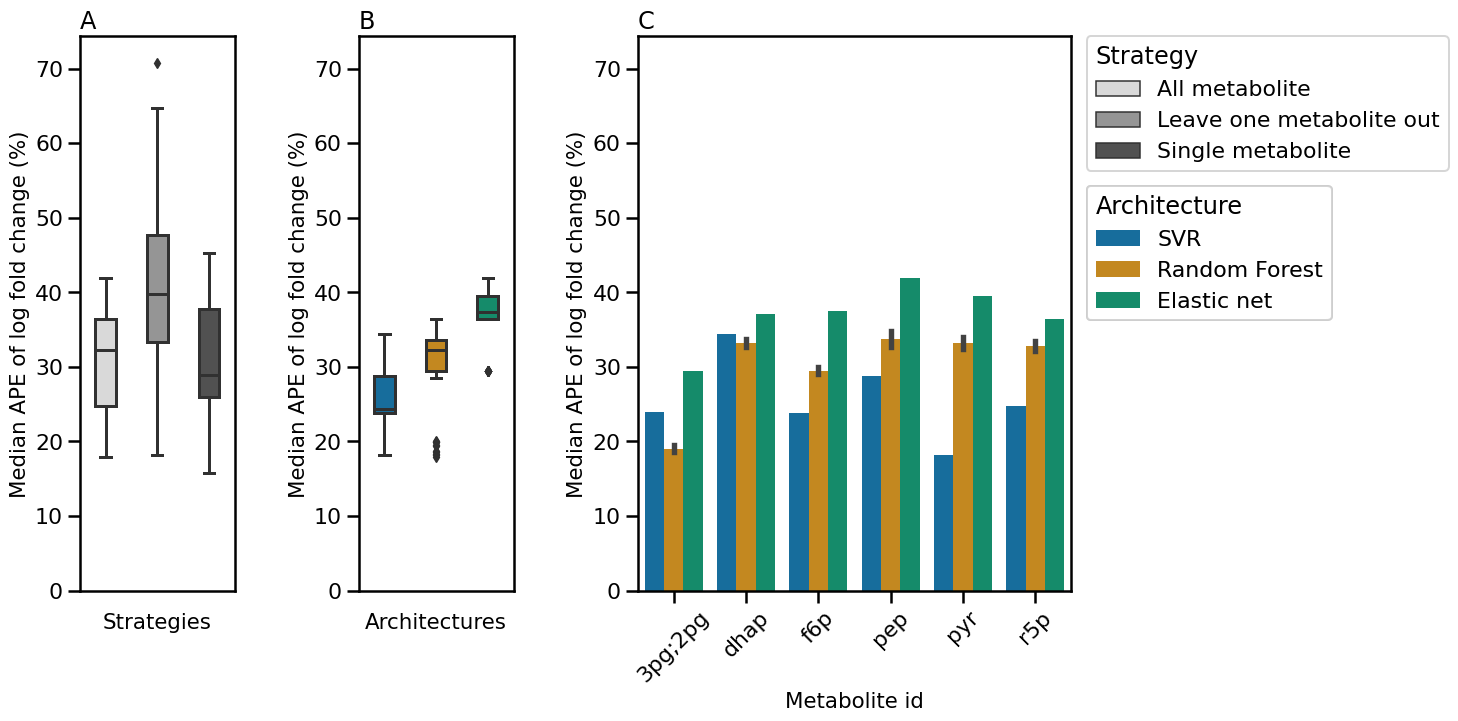

In [12]:
fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all')]

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out',
    'all': 'All metabolite',
    'one_vs_all': 'Single metabolite',
    'metabolite': 'Leave one metabolite out',
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)

make_strategies_plot(_df, ax0)

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ALL)]
_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})
make_architecture_plot(_df, ax1)
make_metabolite_plot(_df, ax2)
leg0, leg1 = make_legend(ax0, ax2)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_0", extra_artists=(leg0, leg1))

In [13]:
_df = full_df.copy()
_df = _df[
    (_df['experiment_id'] == Tier.TIER0) & 
    (_df['architecture'] != 'all') & 
    (_df['strategy'] == Strategy.METABOLITE_CENTRIC) &
    (_df['architecture'] == 'SVR()') &
    ((_df['metabolite_id'] == 'f6p') | (_df['metabolite_id'] == 'pep'))
]


['f6p', 'pep']


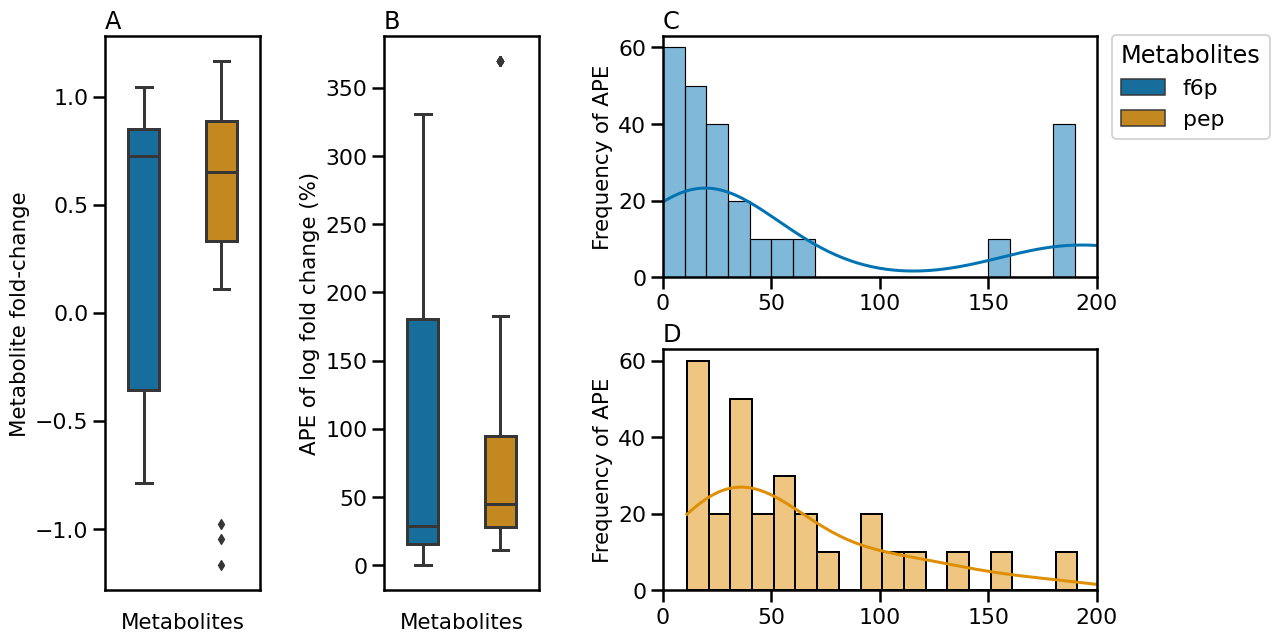

In [14]:
def absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return ape * 100

fig = set_context(MODE)
NROWS, NCOLS = 2, 4
BINWIDTH = 10

_df = full_df.copy()
_df = _df[
    (_df['experiment_id'] == Tier.TIER0) & 
    (_df['architecture'] != 'all') & 
    (_df['strategy'] == Strategy.METABOLITE_CENTRIC) &
    (_df['architecture'] == 'SVR()') &
    ((_df['metabolite_id'] == 'f6p') | (_df['metabolite_id'] == 'pep'))
]


_df
gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8, hspace=.3)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 2:], sharex=ax2, sharey=ax2)

g = sns.boxplot(
    data=_df[_df['repeat_id'] == '0'][['metabolite_id', 'y_true']].explode('y_true'),
    x='metabolite_id',
    y='y_true',
    ax=ax0,
    palette=PLOT_KWARGS[METRIC]['palette'],
    width=.4,
)
g.set(
    xticklabels=[],
    xlabel="Metabolites",
    ylabel='Metabolite fold-change',
    
)
g.tick_params(bottom=False)

_df['ape'] = _df.apply(lambda row: absolute_percentage_error(row['y_true'], row['y_pred']), axis=1)
_df = _df[['metabolite_id', 'ape']].explode('ape').reset_index(drop=True)

g0 = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='ape',
    hue='metabolite_id',
    dodge=False,
    palette=PLOT_KWARGS[METRIC]['palette'],
    width=.4,
    ax=ax1,
)
g0.get_legend().remove()
g0.set(
    xticklabels=[],
    xlabel="Metabolites",
    ylabel='APE of log fold change (%)'
)
g0.tick_params(bottom=False)

g1 = sns.histplot(
    data=_df[_df['metabolite_id'] == 'f6p'],
    x='ape',
    binwidth=BINWIDTH,
    multiple='dodge',
    kde=True,
    ax=ax2,
    color=sns.color_palette('colorblind')[0],
    # element='poly',
)

g1.set(
    xlabel=None,
    ylabel="Frequency of APE",
    xlim=[0, 200]
)

g2 = sns.histplot(
    data=_df[_df['metabolite_id'] == 'pep'],
    x='ape',
    binwidth=BINWIDTH,
    multiple='dodge',
    kde=True,
    ax=ax3,
    color=sns.color_palette('colorblind')[1],
)

g2.set(
    xlabel=None,
    ylabel="Frequency of APE",
    xlim=[0, 200]
)

ax0.set_title("A", loc='left')
ax1.set_title("B", loc='left')
ax2.set_title("C", loc='left')
ax3.set_title("D", loc='left')

handles, labels = ax1.get_legend_handles_labels()
print(labels)
leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 2.35
                                                                     ), title='Metabolites', alignment='left')
# ax2.add_artist(leg0)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_f6p_and_pep", extra_artists=[leg0])

In [15]:
fig = set_context(MODE)
NROWS, NCOLS = 2, 4
BINWIDTH = 10

_df = full_df.copy()
_df = _df[
    (_df['experiment_id'] == Tier.TIER0) & 
    (_df['architecture'] != 'all') & 
    (_df['strategy'] == Strategy.METABOLITE_CENTRIC) &
    (_df['architecture'] == 'SVR()') &
    ((_df['metabolite_id'] == 'f6p') | (_df['metabolite_id'] == 'pep')) & 
    (_df['repeat_id'] == '0')
]
_df

,y_true,y_pred,architecture,metabolite_id,repeat_id,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,correlation,mse_error,mape_error,median_ape_error,adjusted_r2,experiment_id_ordering
530,"[-0.6253263862, 0.6743871663000001, 0.92999752...","[0.7766499218, 0.3668979136, 0.743338752900000...",SVR(),f6p,0,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,Strategy.METABOLITE_CENTRIC,Tier.TIER0,0.44627,NaN,0.412380,80.376492,28.906334,-0.037037,0
1010,"[0.21623249690000002, 0.6326266755000001, 1.08...","[0.611855382, 0.5349142681, 0.4212259549000000...",SVR(),pep,0,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,Strategy.METABOLITE_CENTRIC,Tier.TIER0,0.444171,NaN,0.355023,70.497827,45.218072,-0.013831,0


<Figure size 1279.68x720 with 0 Axes>

## PPI dataset

<Figure size 1279.68x720 with 0 Axes>

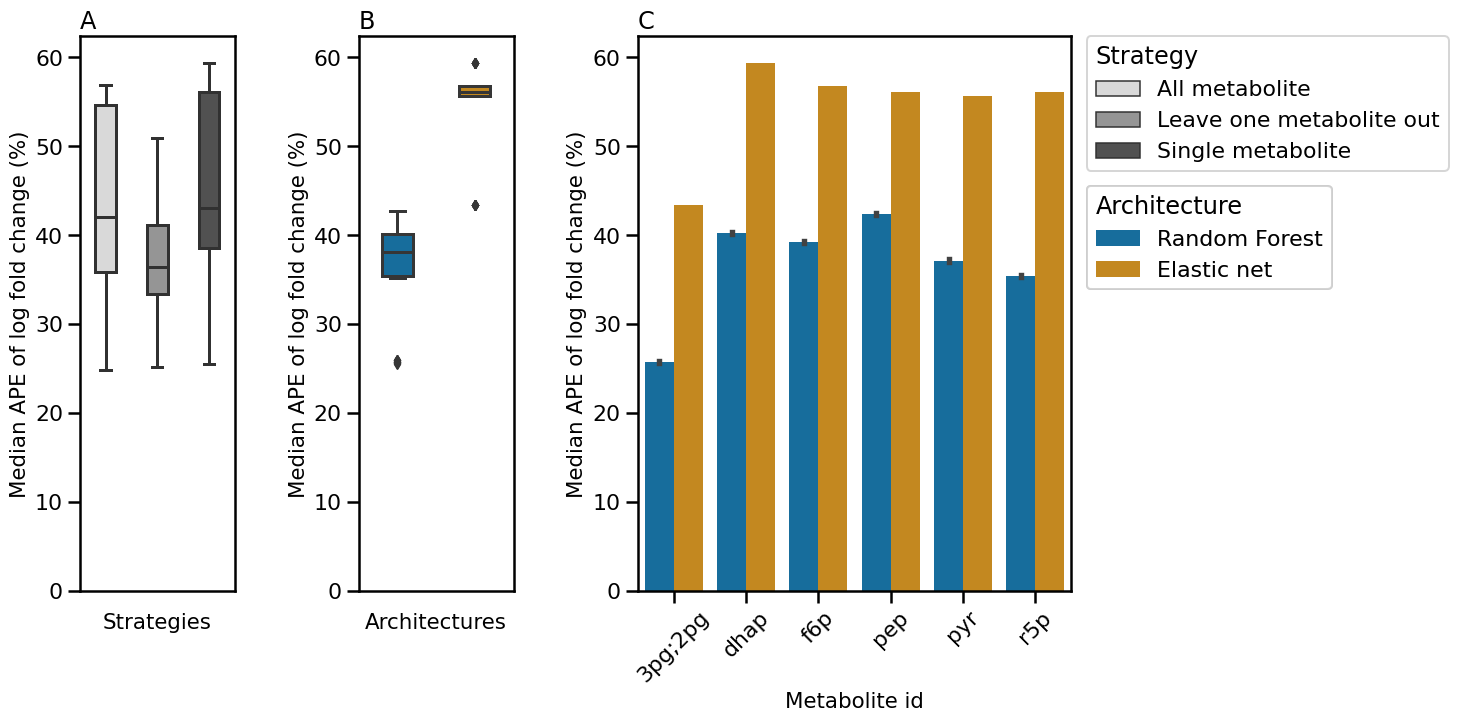

In [16]:
set_context(MODE)
_df = full_df.copy()
_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out',
    'all': 'All metabolite',
    'one_vs_all': 'Single metabolite',
    'metabolite': 'Leave one metabolite out',
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)

make_strategies_plot(_df, ax0)

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ONE_VS_ALL)]
_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})
make_architecture_plot(_df, ax1)
make_metabolite_plot(_df, ax2)
leg0, leg1 = make_legend(ax0, ax2)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_1", extra_artists=(leg0, leg1))

## Stoichiomety protein only

<Figure size 1279.68x720 with 0 Axes>

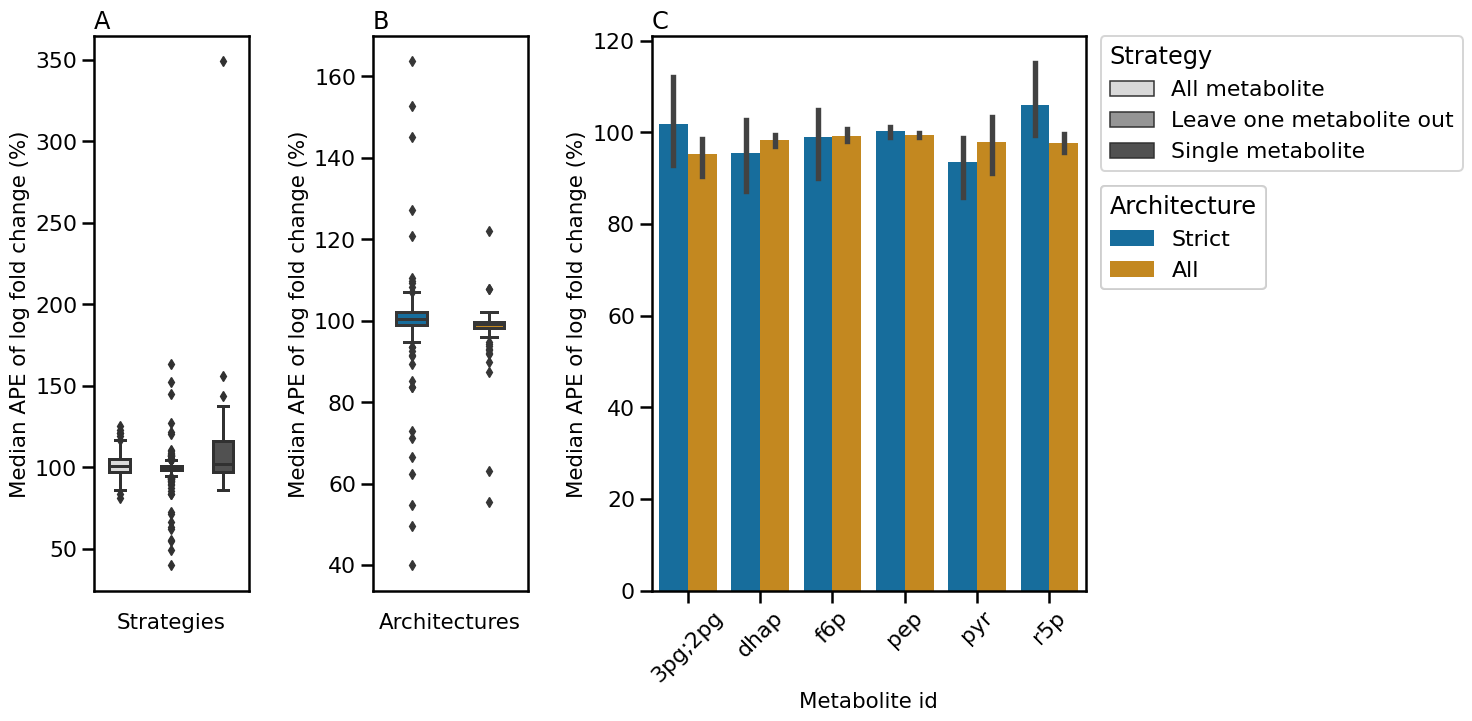

In [17]:
TIER = Tier.TIER2
STRATEGY = Strategy.ONE_VS_ALL
set_context(MODE)
_df = full_df.copy()
_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Single metabolite',
    Strategy.ONE_VS_ALL: 'Leave one metabolite out', 
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2:])

make_strategies_plot(_df, ax0)
ax0.set_title("A", loc='left')

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all') & (_df['strategy'] == STRATEGY)]
_df.architecture = _df.architecture.map({
    "strict": 'Strict', 
    "full": 'All', 
})

make_architecture_plot(_df, ax1)
ax1.set_title("B", loc='left')

make_metabolite_plot(_df, ax2)
ax2.set_title("C", loc='left')

leg0, leg1 = make_legend(ax0, ax2)
save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_2", extra_artists=(leg0, leg1))

## Stoichiometry full model

<Figure size 1279.68x720 with 0 Axes>

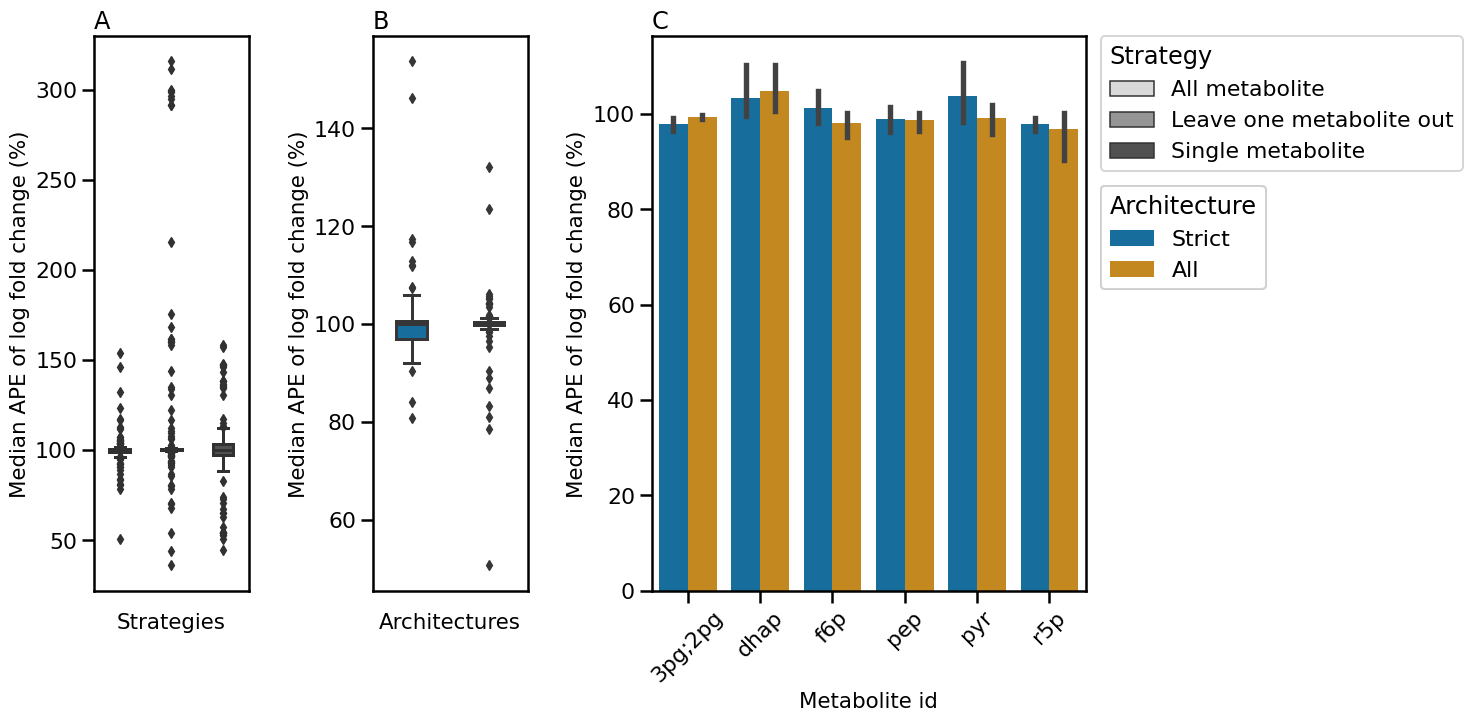

In [18]:
TIER = Tier.TIER3
STRATEGY = Strategy.ALL
set_context(MODE)
_df = full_df.copy()

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Single metabolite',
    Strategy.ONE_VS_ALL: 'Leave one metabolite out', 
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2:])

make_strategies_plot(_df, ax0)
ax0.set_title("A", loc='left')

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all') & (_df['strategy'] == STRATEGY)]
_df.architecture = _df.architecture.map({
    "strict": 'Strict', 
    "full": 'All', 
})

make_architecture_plot(_df, ax1)
ax1.set_title("B", loc='left')

make_metabolite_plot(_df, ax2)
ax2.set_title("C", loc='left')

leg0, leg1 = make_legend(ax0, ax2)
save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_3", extra_artists=(leg0, leg1))

## Strategy comparison
An overview of the effect of using the data strategy for each tier. We see that the `All metabolite` strategy is the best performing strategy over all experiments (Panel A). 

<Figure size 1279.68x720 with 0 Axes>

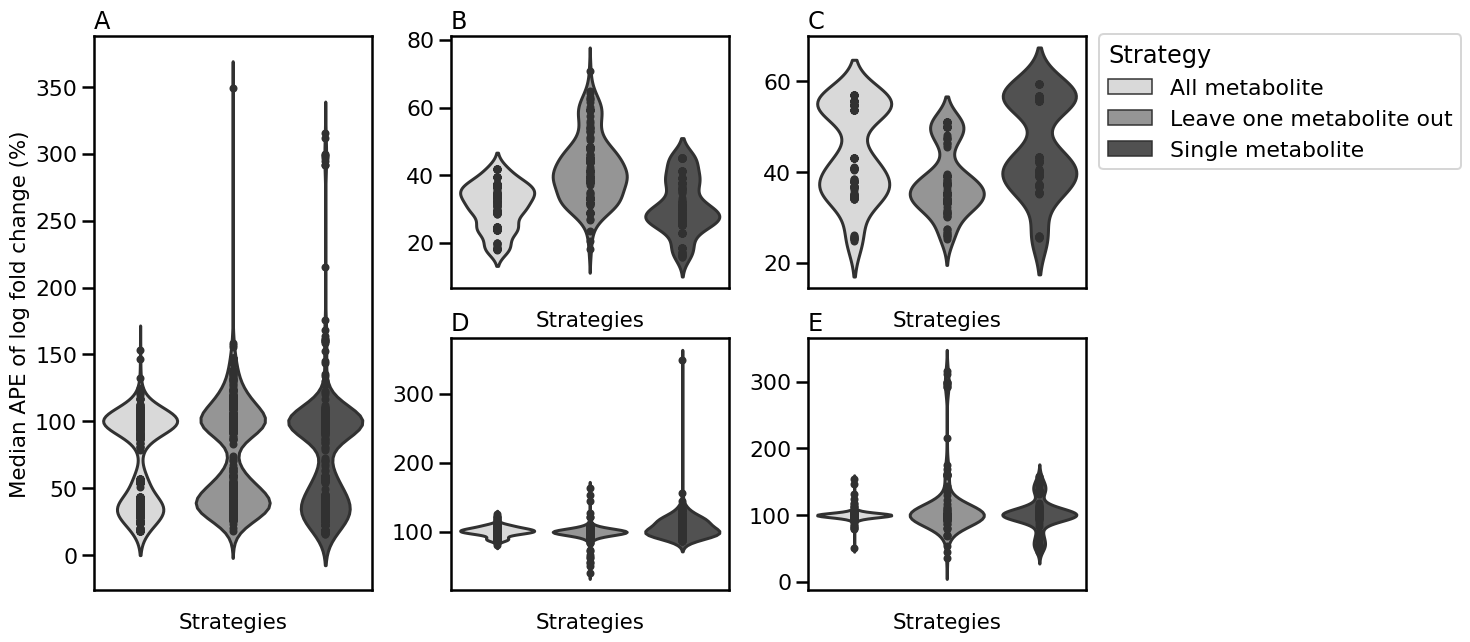

In [19]:
set_context(MODE)
_df = full_df.copy()

fig = set_context(MODE)
NROWS, NCOLS = 2, 6
_df = full_df.copy()
_df = _df[(_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out',
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax2 = fig.add_subplot(gs[0, 4:6])
ax3 = fig.add_subplot(gs[1, 2:4])
ax4 = fig.add_subplot(gs[1, 4:6])

# We reset the dataset long live the copy operator
make_strategies_plot(_df, ax0, plot_type='violin')
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER0)], ax1, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER1)], ax2, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER2)], ax3, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER3)], ax4, plot_type='violin').set(ylabel=None)

ax0.set_title("A", loc='left')
ax1.set_title("B", loc='left')
ax2.set_title("C", loc='left')
ax3.set_title("D", loc='left')
ax4.set_title("E", loc='left')

handles, labels = ax0.get_legend_handles_labels()
leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 2.25), title='Strategy', alignment='left')
# ax2.add_artist(leg0)

# print(handles)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_strategies_over_all_plots", extra_artists=[leg0])
plt.show()

## Tier comparison

In [20]:
_df = full_df.copy()
_df = _df[
    (_df['architecture'] != 'all') &
    (
        ((_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == Strategy.ALL) & (_df['architecture'] == 'SVR()')) |
        ((_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'RandomForestRegressor()')) |
        ((_df['experiment_id'] == Tier.TIER2) & (_df['strategy'] == Strategy.ONE_VS_ALL) & (_df['architecture'] == 'strict')) |
        ((_df['experiment_id'] == Tier.TIER3) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'strict')) 
    )
]
_df

,y_true,y_pred,architecture,metabolite_id,repeat_id,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,correlation,mse_error,mape_error,median_ape_error,adjusted_r2,experiment_id_ordering
10,"[0.6650874879, 0.4727928061, -1.150331301, 0.9...","[0.7005134695, 0.6452728073, -0.026530319, 0.7...",SVR(),3pg;2pg,0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.328537,NaN,0.248327,41.645353,23.941691,0.568823,0
11,"[0.6650874879, 0.4727928061, -1.150331301, 0.9...","[0.7005134695, 0.6452728073, -0.026530319, 0.7...",SVR(),3pg;2pg,1,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.328537,NaN,0.248327,41.645353,23.941691,0.568823,0
12,"[0.6650874879, 0.4727928061, -1.150331301, 0.9...","[0.7005134695, 0.6452728073, -0.026530319, 0.7...",SVR(),3pg;2pg,2,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.328537,NaN,0.248327,41.645353,23.941691,0.568823,0
13,"[0.6650874879, 0.4727928061, -1.150331301, 0.9...","[0.7005134695, 0.6452728073, -0.026530319, 0.7...",SVR(),3pg;2pg,3,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.328537,NaN,0.248327,41.645353,23.941691,0.568823,0
14,"[0.6650874879, 0.4727928061, -1.150331301, 0.9...","[0.7005134695, 0.6452728073, -0.026530319, 0.7...",SVR(),3pg;2pg,4,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.328537,NaN,0.248327,41.645353,23.941691,0.568823,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.002068353584036231, -0.002068612026050687,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,1.109843,0.025546,0.658881,100.086477,100.240773,-0.037037,3
4130,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.008101633749902248, -0.008102219551801682,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.880095,0.233839,0.659147,100.338734,100.943102,-0.037037,3
4131,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.009108763188123703, -0.009088517166674137,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.878248,0.253064,0.659197,100.380847,101.059726,-0.037037,3
4132,"[0.6518658995628357, -1.3485695123672485, 0.17...","[0.001019663061015308, 0.003810988273471594, 0...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.877988,-0.273758,0.658736,99.867432,99.920972,-0.037037,3


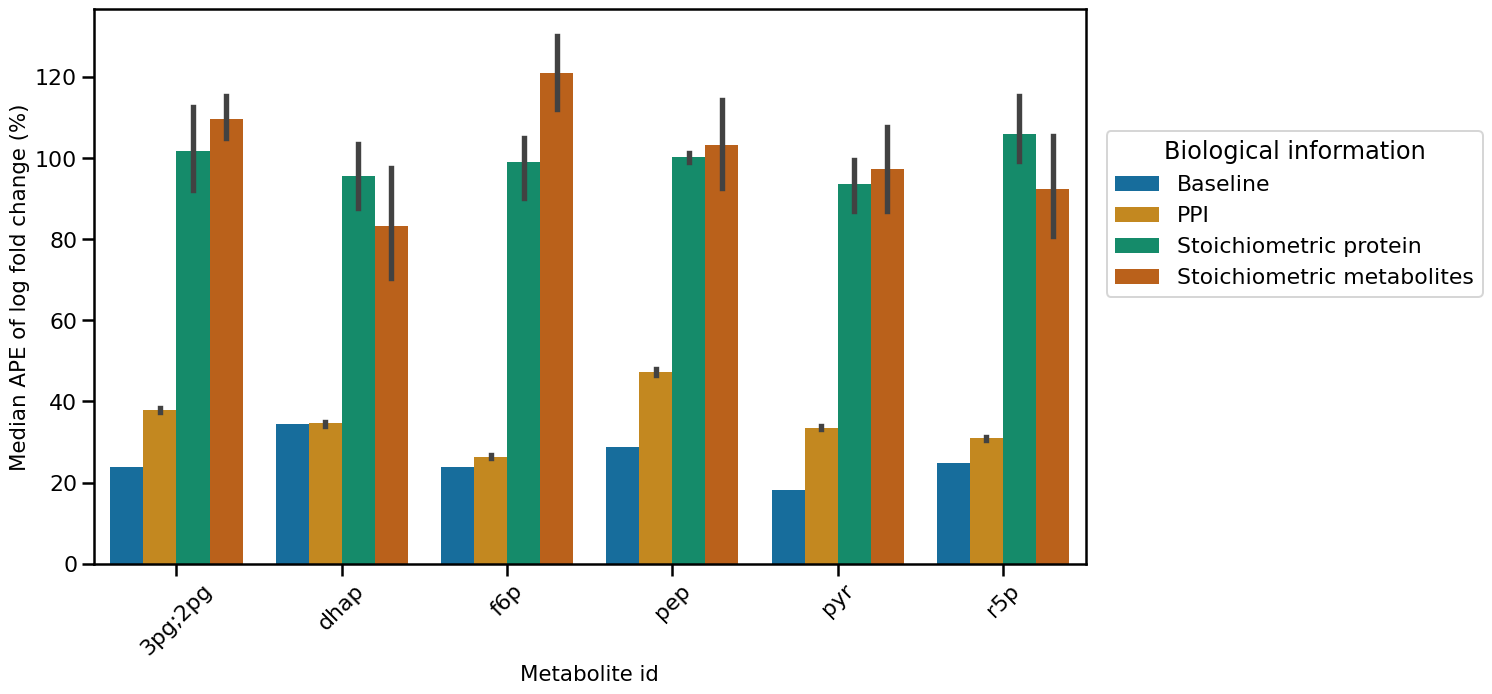

In [21]:
set_context(MODE)
_df = full_df.copy()
_df = _df[
    (_df['architecture'] != 'all') &
    (
        ((_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == Strategy.ALL) & (_df['architecture'] == 'SVR()')) |
        ((_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'RandomForestRegressor()')) |
        ((_df['experiment_id'] == Tier.TIER2) & (_df['strategy'] == Strategy.ONE_VS_ALL) & (_df['architecture'] == 'strict')) |
        ((_df['experiment_id'] == Tier.TIER3) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'strict')) 
    )
]

_df.experiment_id = _df.experiment_id.map({
    Tier.TIER0: 'Baseline', 
    Tier.TIER1: 'PPI', 
    Tier.TIER2: 'Stoichiometric protein',
    Tier.TIER3: 'Stoichiometric metabolites',
})

g = sns.barplot(
    data=_df,
    hue='experiment_id',
    **PLOT_KWARGS[METRIC],
)


g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
leg0 = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Biological information')

g.set(
    xlabel='Metabolite id',
    **SET_KWARGS[METRIC]
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_different_tiers_using_optimal_model", extra_artists=[leg0])

# Deep dive into pyruvate

In [22]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7fc63c2a8b20>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7fc63c2a8d30>>])


In [23]:
# PDC1, PDC2, PDC5, PDC6
pdc_enzymes = ["YLR044C", "YDR081C", "YLR134W", "YGR087C"]

for pdc_enzyme in pdc_enzymes:
    if pdc_enzyme in tf.x.columns:
        print(pdc_enzyme)

YLR044C
YGR087C


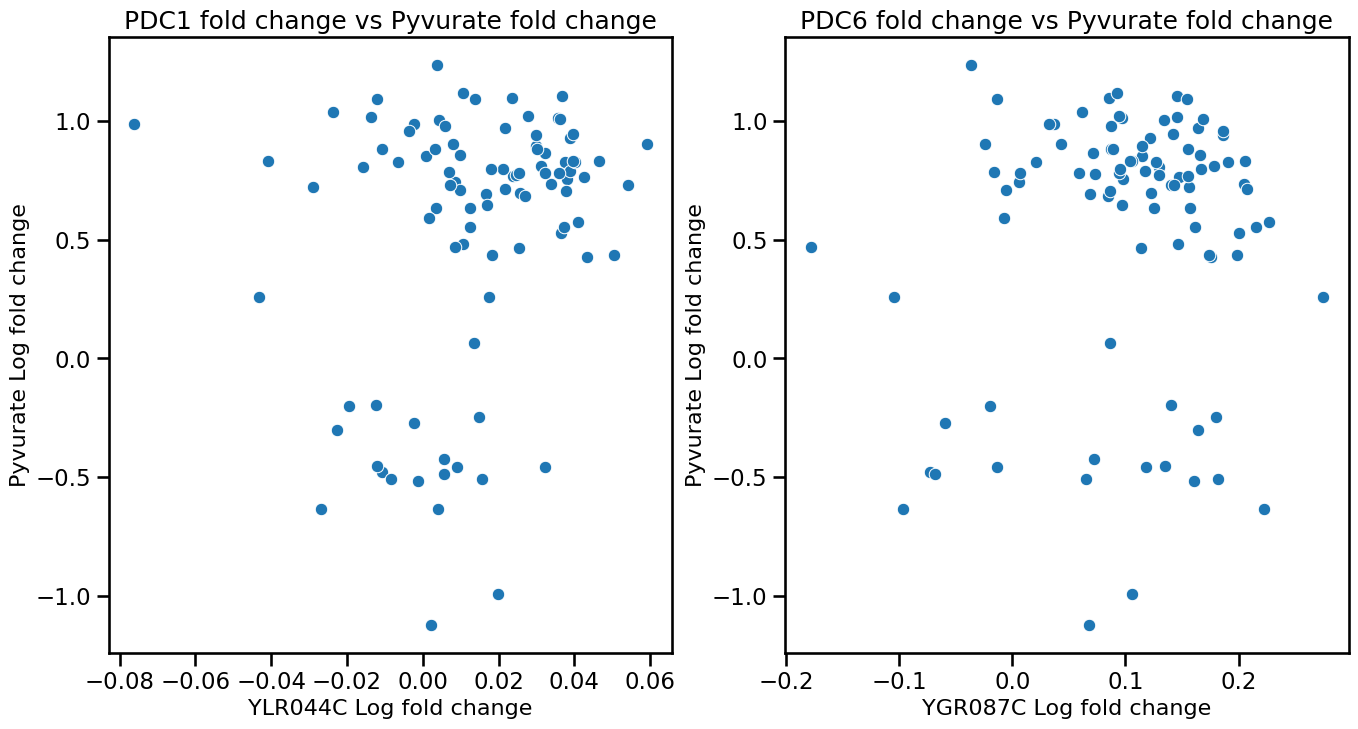

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="pyr",
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="pyr",
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()

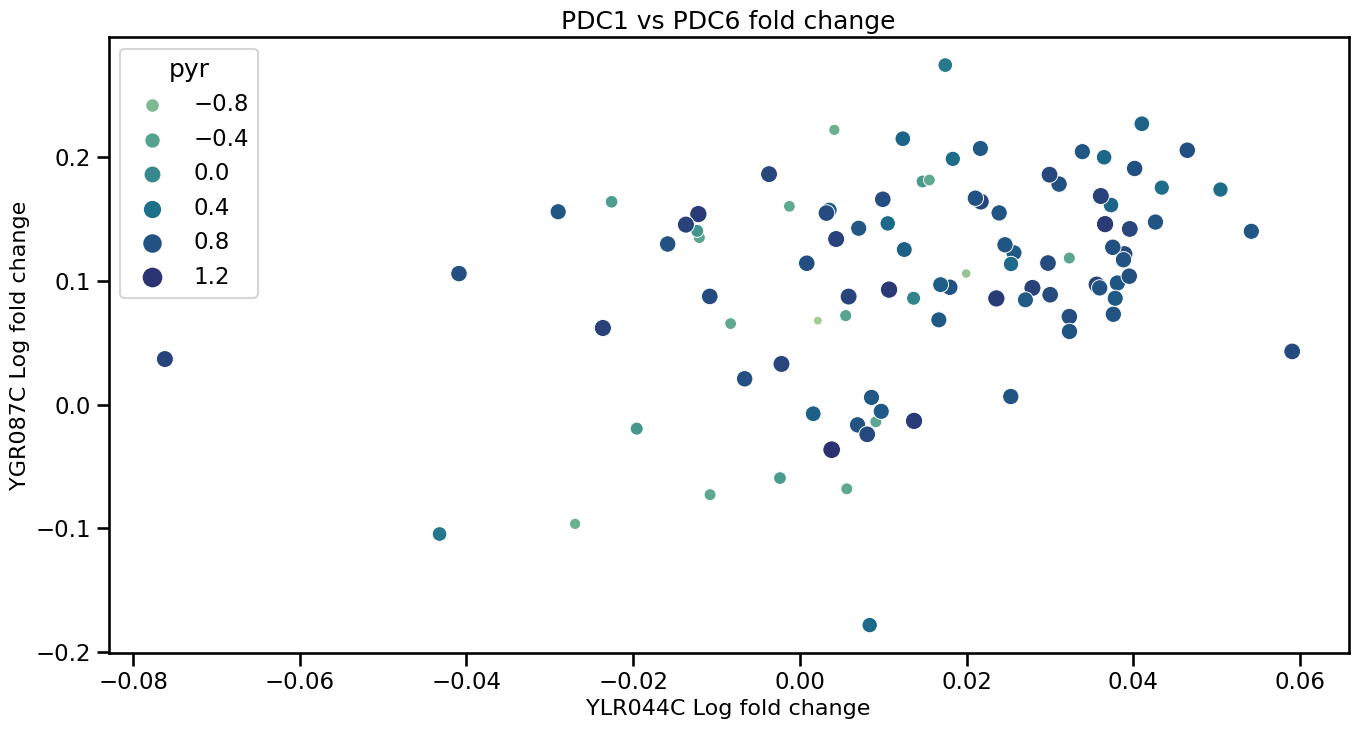

In [25]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="YGR087C",
    hue='pyr',
    size='pyr',
    palette='crest',
    ax=ax1,
).set(
    title='PDC1 vs PDC6 fold change',
    xlabel='YLR044C Log fold change',
    ylabel='YGR087C Log fold change'
)
plt.show()

# Load optimal model

In [26]:
with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

predictions = model.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_metabolite = model_tier_0_metabolite_strategy.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_one_vs_all = model_tier_0_one_vs_all.predict(tf.x.xs(key='pyr', axis=0, level=1))

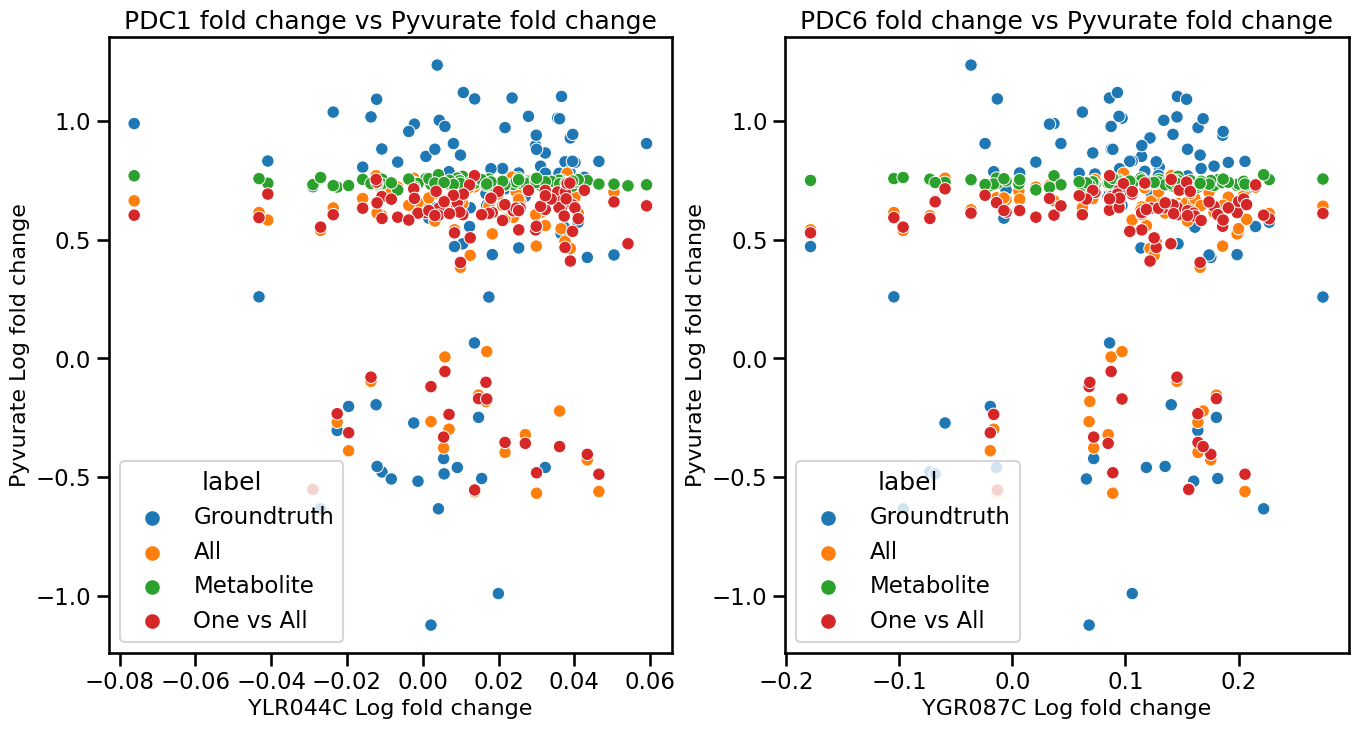

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

_df = _df.assign(predictions=predictions)
_df = _df.assign(predictions_metabolite=predictions_metabolite)
_df = _df.assign(predictions_one_vs_all=predictions_one_vs_all)
_df = _df[['YLR044C', 'YGR087C', 'pyr', 'predictions', 'predictions_metabolite', 'predictions_one_vs_all']].reset_index()

_df = pd.concat([
    _df[['YLR044C', 'YGR087C', 'pyr']].rename({'pyr': 'fc'}, axis=1).assign(label='Groundtruth'),
    _df[['YLR044C', 'YGR087C', 'predictions']].rename({'predictions': 'fc'}, axis=1).assign(label='All'),
    _df[['YLR044C', 'YGR087C', 'predictions_metabolite']].rename({'predictions_metabolite': 'fc'}, axis=1).assign(label='Metabolite'),
    _df[['YLR044C', 'YGR087C', 'predictions_one_vs_all']].rename({'predictions_one_vs_all': 'fc'}, axis=1).assign(label='One vs All'),
], axis=0, ignore_index=True)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="fc",
    hue='label',
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="fc",
    hue='label',
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()